In [1]:
from pathlib import Path
import pandas as pd
from idf_analysis.idf_class import IntensityDurationFrequencyAnalyse
from idf_analysis.definitions import *
from idf_analysis import __version__
print(f'{__version__=}')

__version__='0.4.0'


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Intensity Duration Frequency Analyse (DWA, 2025)

## Parameter

**series_kind**:

`SERIES.PARTIAL` = Partielle Serie (partial duration series, PDS) (peak over threshold, POT)

`SERIES.ANNUAL` = Jährliche Serie (annual maximum series, AMS) - DWA (2025) recommends this series

**worksheet**:

`METHOD.DWA_2025`:
- DWA-A 531 (2025)
- Parameter formula continuous for full duration span

`METHOD.KOSTRA`:
- DWA-A 531 (2012)
- KOSTRA - recommented
- Parameter formula change at 60 min and 12 h

`METHOD.CONVECTIVE_ADVECTIVE`:
- DWA-A 531
- Unterscheidung in überwiegend konvektiv und advektiv verursachte Starkregen
- Parameter formula change at 3 h and 24 h

`METHOD.ATV`:
- ATV-A 121
- Parameter formula change at 3 h and 48 h

**extended_durations** = Includes the durations steps `[0.75d, 1d, 2d, 3d, 4d, 5d, 6d]` in the analysis (d=days)

Default duration steps `[5m, 10m, 15m, 20m, 30m, 45m, 60m, 1.5h, 3h, 4.5h, 6h, 7.5h, 10h, 12h]`

In [3]:
idf = IntensityDurationFrequencyAnalyse(series_kind=SERIES.ANNUAL, worksheet=METHOD.DWA_2025, extended_durations=True)

The data used for this calculation is a timeseries of precipitation observations.
The data can be passed in mm or inch.
The series should contain measured volumes and not intensities.
The intervall of the series can be chosen freely, but should ideally be already time equidistant.
But the results will only show duration steps that are greater or equal to the intervall. 

I used the rain-time-series from ehyd.gv.at with the ID 112086 (Graz-Andritz) [created with the ehyd-tools package](https://github.com/MarkusPic/ehyd_tools/blob/main/example/example_python_api.ipynb).

You need to install `pyarrow` or `fastparquet` to read and write parquet files.

In [4]:
data = pd.read_parquet('ehyd_112086.parquet').squeeze('columns')

Get a look at the time-series

In [5]:
data.head()

datetime
2007-09-17 13:56:00    0.0
2007-09-17 13:57:00    0.0
2007-09-17 13:58:00    0.0
2007-09-17 13:59:00    0.0
2007-09-17 14:00:00    0.0
Name: N-Minutensummen-112086, dtype: float64

In [6]:
data.tail()

datetime
2019-12-31 23:56:00    0.0
2019-12-31 23:57:00    0.0
2019-12-31 23:58:00    0.0
2019-12-31 23:59:00    0.0
2020-01-01 00:00:00    NaN
Name: N-Minutensummen-112086, dtype: float64

Set the time-series to be used for the calculation of the IDF parameters 

In [7]:
idf.set_series(data)

define a working directory to save some plots and interim results

In [8]:
output_directory = Path('ehyd_112086_idf_data_new')

Intermediate results are created for each new calculation, which are only dependent on the selected series `series_kind` and the specified/required duration steps. This process takes a few seconds.
In addition, these intermediate results contain the parameters required to calculate the rainfall height.
The calculation methods and formula-change-durations according to the selected `worksheet` are already taken into account here.

In [9]:
idf.write_parameters(output_directory / 'idf_parameters.yaml')

/Users/markus/PycharmProjects/.venv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating Intensities for duration 8640: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


To save time, it is possible to save the parameters temporarily and when the script is called up again, these parameters are no longer calculated but read from the file.

In [10]:
idf.auto_save_parameters(output_directory / 'idf_parameters.yaml')

These interim results can be called up with:

In [13]:
idf.parameters._parameter_values

{'eta': 0.8170122825106468,
 'loc': 14.050191266395858,
 'scale': 4.780466857553214,
 'shape': -0.1,
 'theta': 8.318942091673822}

In [14]:
idf.parameters

plot the interim results for the final parameters of the function to calculate the rainfall height depending on duration and return periods.

## Calculations

In [16]:
idf.depth_of_rainfall(duration=15, return_period=1)

np.float64(16.081944945454794)

In [17]:
print('Resulting rainfall height h_N(T_n={t:0.1f}a, D={d:0.1f}min) = {h:0.2f} mm'
      ''.format(t=1, d=15, h=idf.depth_of_rainfall(15, 1)))

Resulting rainfall height h_N(T_n=1.0a, D=15.0min) = 16.08 mm


In [18]:
idf.rain_flow_rate(duration=15, return_period=1)

np.float64(178.68827717171993)

In [19]:
print('Resulting rainfall flow rate r_N(T_n={t:0.1f}a, D={d:0.1f}min) = {r:0.2f} L/(s*ha)'
      ''.format(t=1, d=15, r=idf.rain_flow_rate(15, 1)))

Resulting rainfall flow rate r_N(T_n=1.0a, D=15.0min) = 178.69 L/(s*ha)


In [20]:
idf.r_720_1()

np.float64(10.739376745521536)

In [21]:
idf.get_return_period(height_of_rainfall=10, duration=15)

np.float64(0.30780580092695775)

In [22]:
idf.get_duration(height_of_rainfall=10, return_period=1)

np.float64(6.407029064330444)

In [23]:
idf.result_table().round(2)

,1,2,3,5,10,20,25,30,50,75,100
5,8.47,10.54,11.82,13.50,15.93,18.44,19.34,20.08,22.23,24.00,25.31
10,13.06,16.25,18.22,20.82,24.56,28.42,29.80,30.95,34.26,37.00,39.01
15,16.08,20.01,22.44,25.64,30.25,35.01,36.71,38.12,42.20,45.57,48.04
20,18.30,22.76,25.52,29.17,34.41,39.82,41.76,43.37,48.01,51.84,54.66
30,21.44,26.67,29.90,34.17,40.32,46.66,48.93,50.81,56.24,60.74,64.04
45,24.55,30.54,34.25,39.13,46.17,53.43,56.03,58.19,64.41,69.56,73.33
60,26.73,33.26,37.29,42.61,50.28,58.18,61.01,63.36,70.13,75.74,79.85
90,29.78,37.05,41.55,47.47,56.01,64.82,67.97,70.59,78.14,84.38,88.96
120,31.94,39.74,44.56,50.92,60.08,69.53,72.91,75.71,83.81,90.51,95.42
180,35.02,43.57,48.86,55.83,65.88,76.23,79.94,83.01,91.89,99.24,104.62


In [24]:
idf.result_table(add_names=True).round(2)

return period (a),1,2,3,5,10,20,25,30,50,75,100
frequency (1/a),1.000,0.500,0.333,0.200,0.100,0.050,0.040,0.033,0.020,0.013,0.010
duration (min),,,,,,,,,,,
5,8.47,10.54,11.82,13.50,15.93,18.44,19.34,20.08,22.23,24.00,25.31
10,13.06,16.25,18.22,20.82,24.56,28.42,29.80,30.95,34.26,37.00,39.01
15,16.08,20.01,22.44,25.64,30.25,35.01,36.71,38.12,42.20,45.57,48.04
20,18.30,22.76,25.52,29.17,34.41,39.82,41.76,43.37,48.01,51.84,54.66
30,21.44,26.67,29.90,34.17,40.32,46.66,48.93,50.81,56.24,60.74,64.04
45,24.55,30.54,34.25,39.13,46.17,53.43,56.03,58.19,64.41,69.56,73.33
60,26.73,33.26,37.29,42.61,50.28,58.18,61.01,63.36,70.13,75.74,79.85
90,29.78,37.05,41.55,47.47,56.01,64.82,67.97,70.59,78.14,84.38,88.96


To save the table as a csv:

In [25]:
idf.result_table(add_names=True).round(2).to_csv(output_directory / 'idf_table_UNIX.csv', sep=',', decimal='.', float_format='%0.2f')

In [26]:
print(idf.result_table(add_names=True).round(2).to_string())

return period (a)    1      2       3       5       10      20      25      30      50      75      100
frequency (1/a)    1.000  0.500   0.333   0.200   0.100   0.050   0.040   0.033   0.020   0.013   0.010
duration (min)                                                                                         
5                   8.47  10.54   11.82   13.50   15.93   18.44   19.34   20.08   22.23   24.00   25.31
10                 13.06  16.25   18.22   20.82   24.56   28.42   29.80   30.95   34.26   37.00   39.01
15                 16.08  20.01   22.44   25.64   30.25   35.01   36.71   38.12   42.20   45.57   48.04
20                 18.30  22.76   25.52   29.17   34.41   39.82   41.76   43.37   48.01   51.84   54.66
30                 21.44  26.67   29.90   34.17   40.32   46.66   48.93   50.81   56.24   60.74   64.04
45                 24.55  30.54   34.25   39.13   46.17   53.43   56.03   58.19   64.41   69.56   73.33
60                 26.73  33.26   37.29   42.61   50.28   58.18 

To create a color plot of the IDF curves:

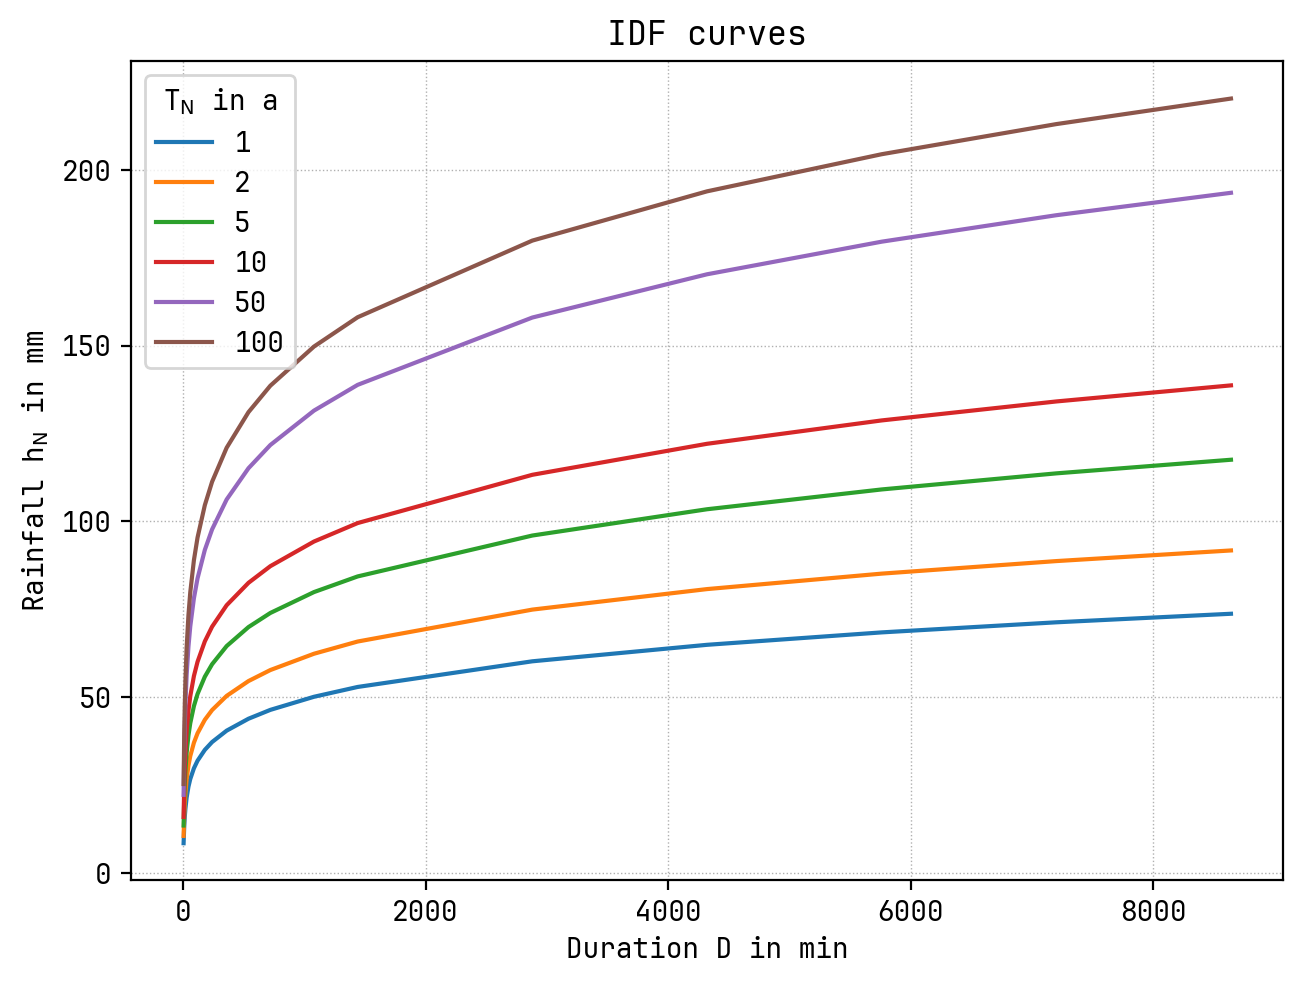

In [27]:
fig, ax = idf.curve_figure(color=True)

To create a black/white plot of the IDF curves:

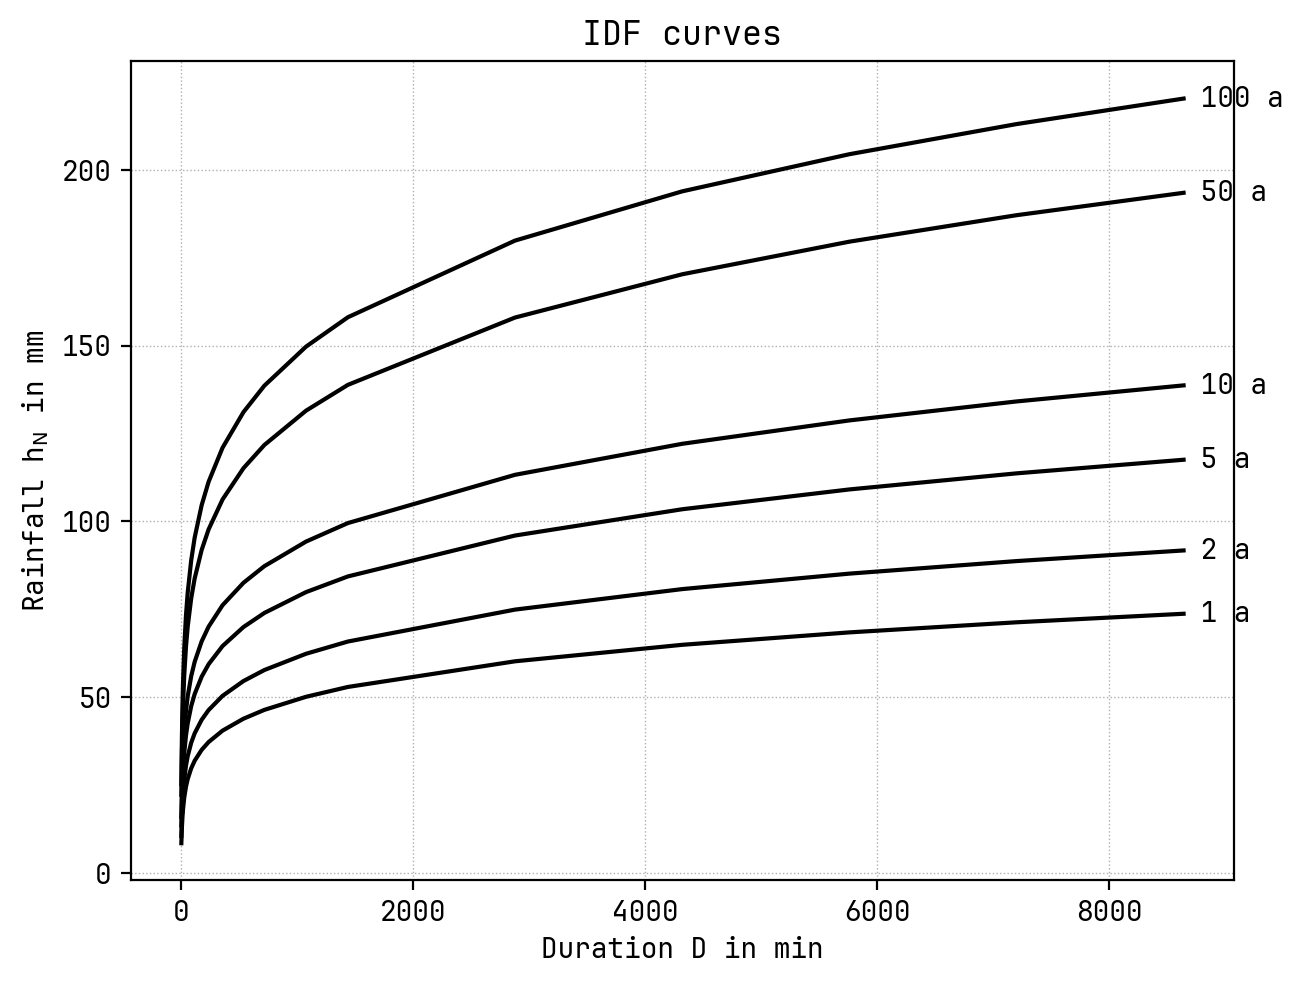

In [29]:
fig, ax = idf.curve_figure(color=False)

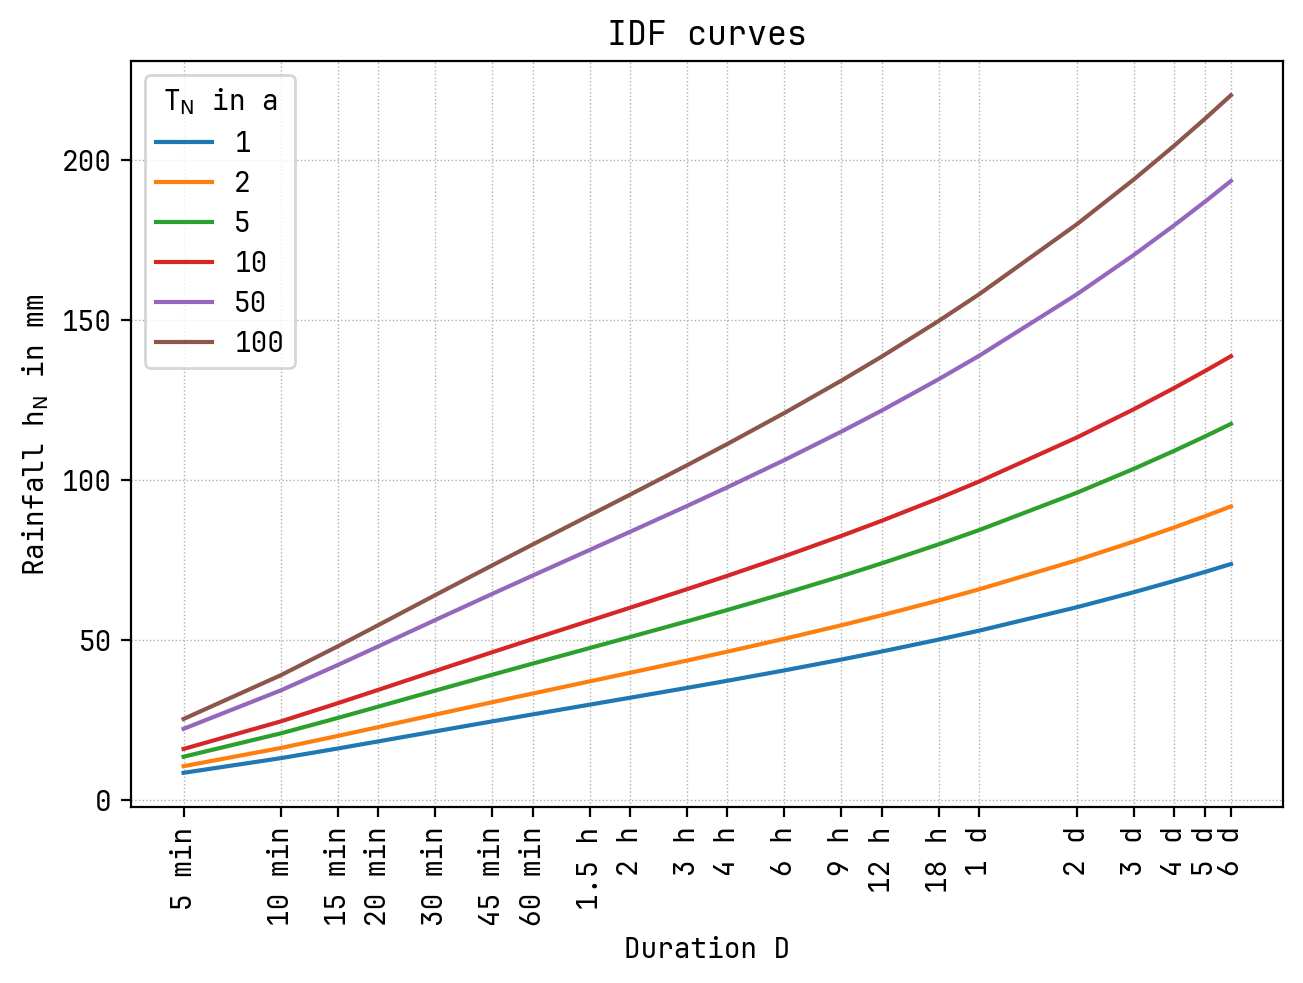

In [30]:
fig, ax = idf.curve_figure(color=True, logx=True, duration_steps_ticks=True)